In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

from data_generators import *
import glob
import cv2

In [5]:
labels_file = open('./data/train.txt', 'r')
labels = [float(line) for line in labels_file]

In [6]:
vid = cv2.VideoCapture('./data/train.mp4')

rows, cols, channels = 480, 640, 3
frame = np.zeros((rows, cols, channels)).astype('uint8')
# src_color = []
src = []
max_frames = 0
nframes = 0
# while(i < 10):
while(1):
    # Capture frame-by-frame
    try:
        ret, frame[:] = vid.read()
        nframes += 1
    except:
        break

    # Our operations on the frame come here
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
#     src_color.append(frame)
#     src.append(gray.astype('float')/255.0)
    

print(nframes)

20400


In [ ]:
vid = cv2.VideoCapture('./data/train.mp4')

rows, cols, channels = 480, 640, 3
grays = np.memmap('gray_frames.npy', dtype=np.float32,
              mode='w+', shape=(rows, cols, nframes))
print(grays.shape)
idx = 0
while(1):
    # Capture frame-by-frame
    try:
        ret, frame[:] = vid.read()
        grays[:, :, idx] = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype('float')/255.0
        idx += 1
    except:
        break




In [5]:
fw = 4.

thresh = 20.0/255.0

diff = []
dvs = []
refs = []
ref = src[0].copy()
for i in range(1, len(src)):
    d = src[i] - ref
    td = d * (np.abs(d) > thresh)
    ref += td
    
    diff.append(d)
    dvs.append(td)
    refs.append(ref.copy())
    
    

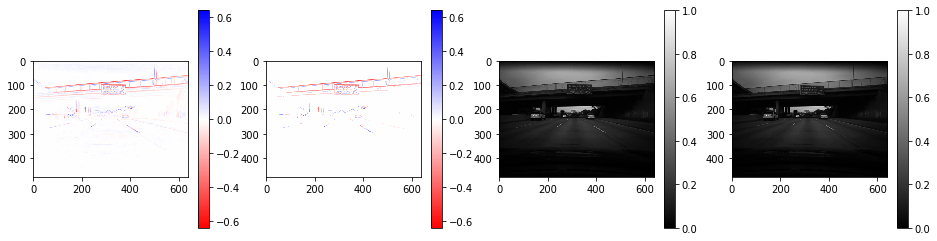

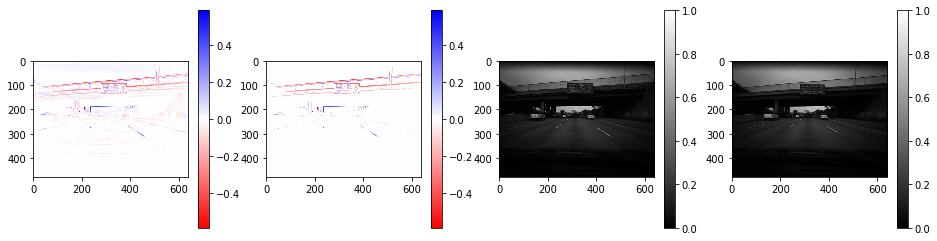

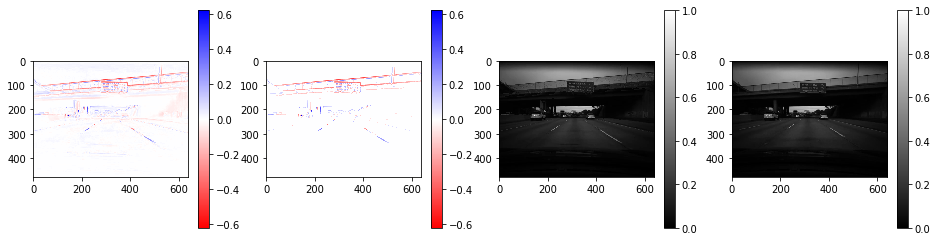

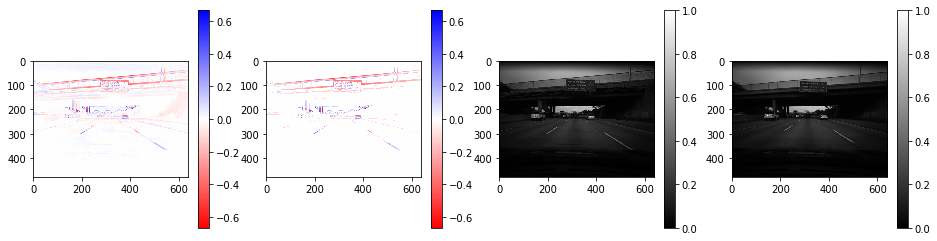

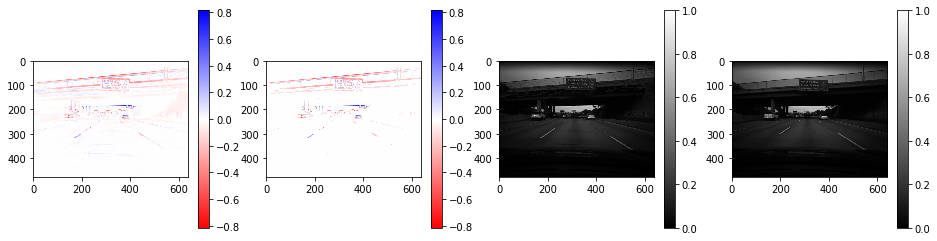

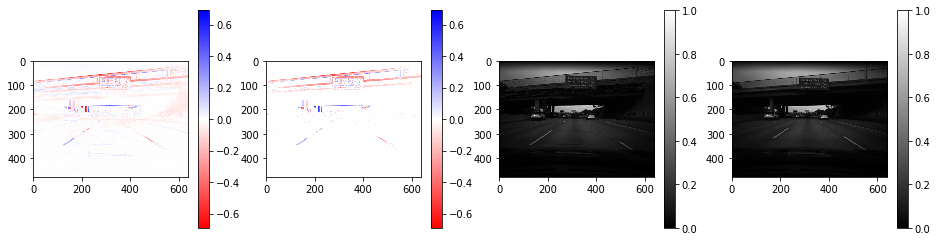

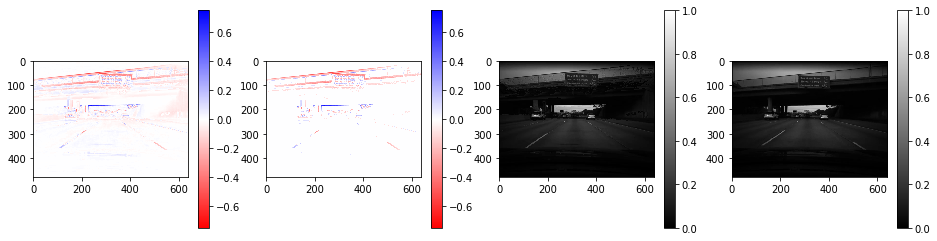

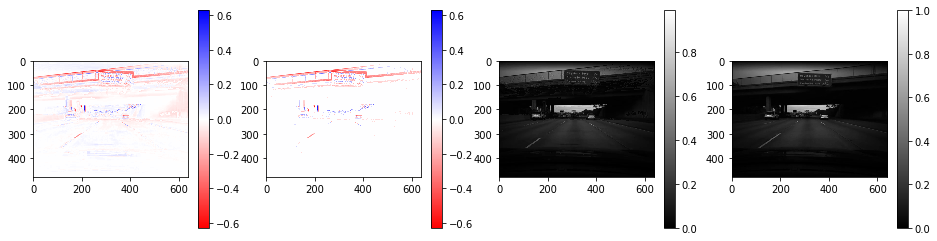

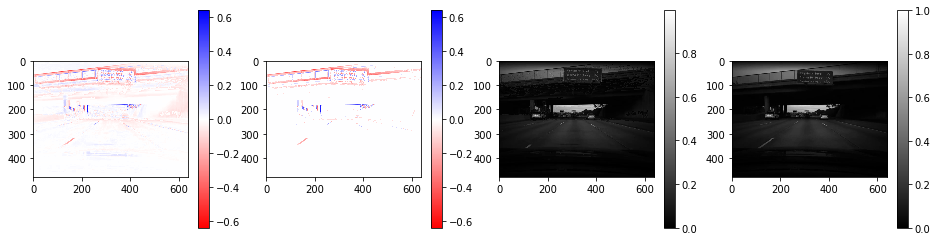

In [7]:
for i in range(len(diff)):
    fig = plt.figure(figsize=(4*fw, fw))
    ax = plt.subplot(1, 4, 1)
    im = plt.imshow(diff[i], cmap='bwr_r', 
                   vmin=-np.abs(diff[i]).max(),
                   vmax=np.abs(diff[i]).max())
    plt.colorbar(im)

    ax = plt.subplot(1, 4, 2)
    im = plt.imshow(dvs[i], cmap='bwr_r',
                   vmin=-np.abs(dvs[i]).max(),
                   vmax=np.abs(dvs[i]).max())
    plt.colorbar(im)

    ax = plt.subplot(1, 4, 3)
    im = plt.imshow(refs[i], cmap='gray')
    plt.colorbar(im)

    ax = plt.subplot(1, 4, 4)
    im = plt.imshow(src[i], cmap='gray')
    plt.colorbar(im)

plt.show()


28.105569
float64
(480, 640, 3)


error: OpenCV(4.1.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<3, 4>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = (cv::impl::<unnamed>::SizePolicy)2u; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


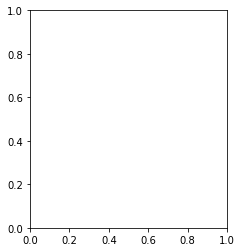

In [5]:
import glob
files = sorted(glob.glob("./train/data_*.npz"))
fw = 4.0
for f in files[:10]:
    data = np.load(f)
    gray = data['gray']
    dvs = data['dvs']
    color = data['color']
    label = data['label']
    print(label)
    
    print(color.dtype)
    print(color.shape)
    plt.figure(figsize=(fw*3, fw))
    ax = plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor((color*255).astype('uint8'), cv2.COLOR_BGR2RGB))

    ax = plt.subplot(1, 3, 2)
    plt.imshow(gray, cmap='gray', 
               vmin=0.0,
               vmax=1.0,
               )

    ax = plt.subplot(1, 3, 3)
    plt.imshow(dvs, cmap='bwr_r',
               vmin=-1.0,
               vmax=1.0,
              )

    plt.show()

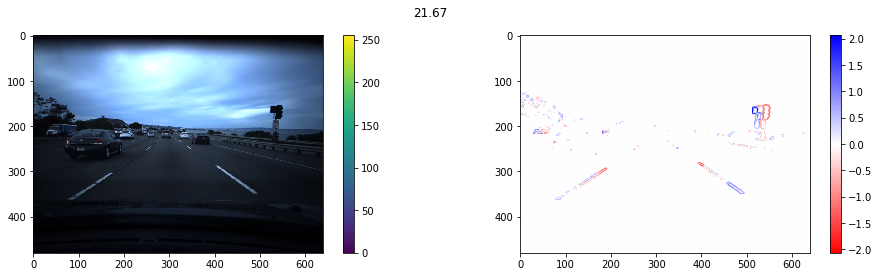

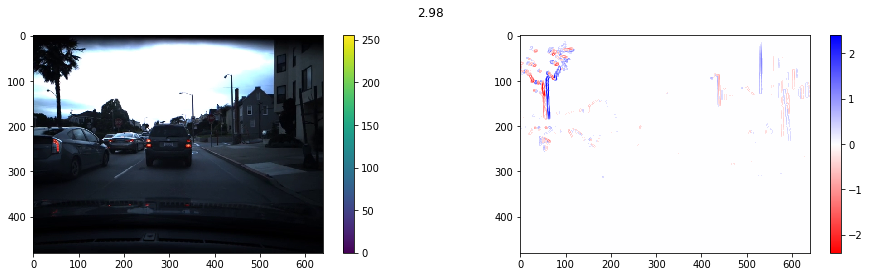

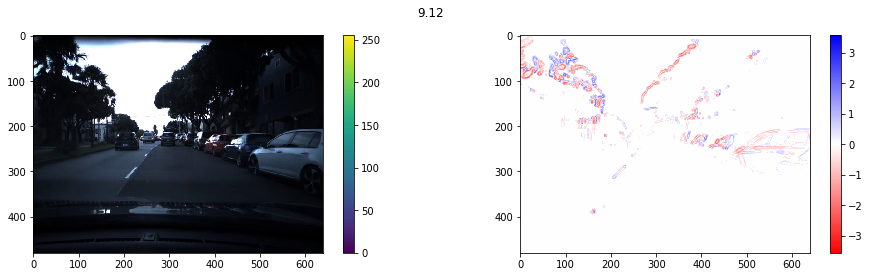

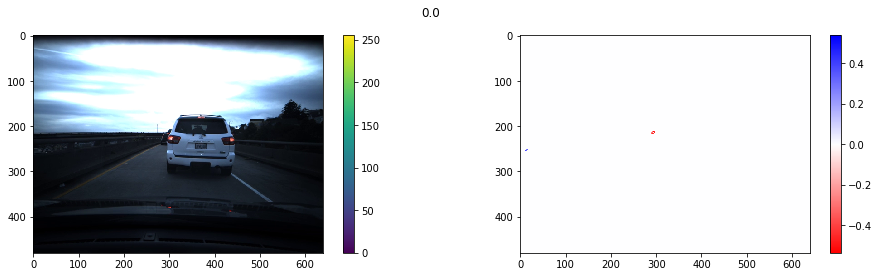

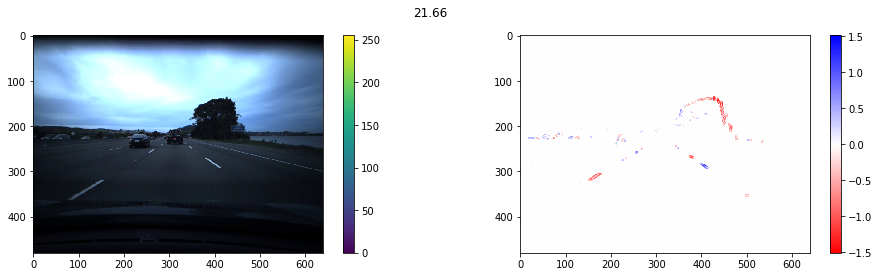

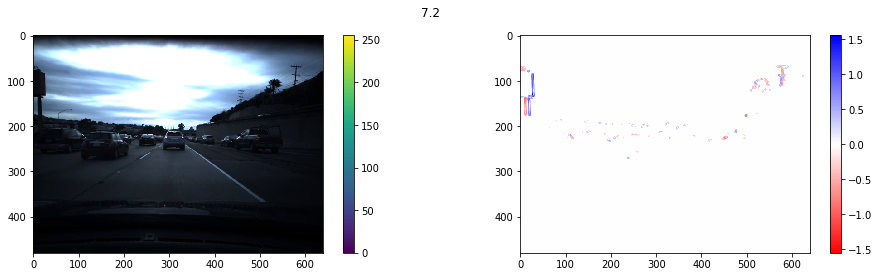

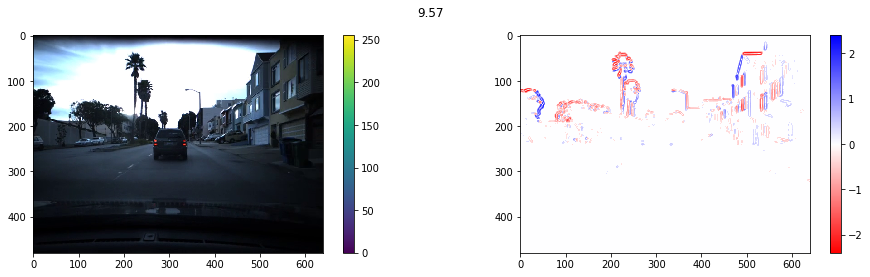

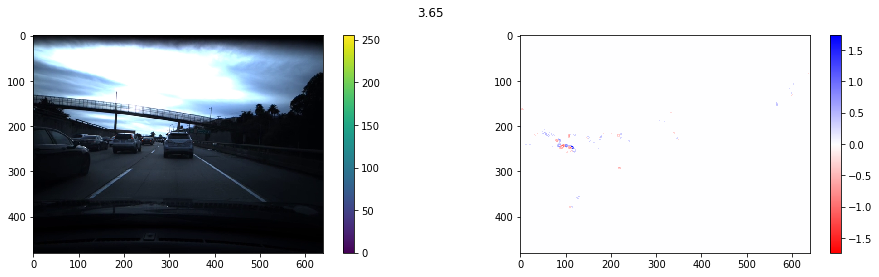

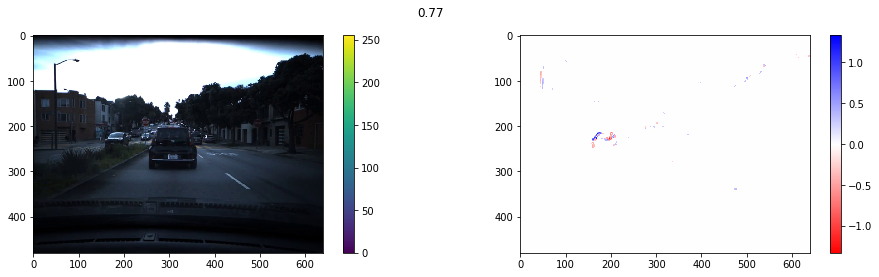

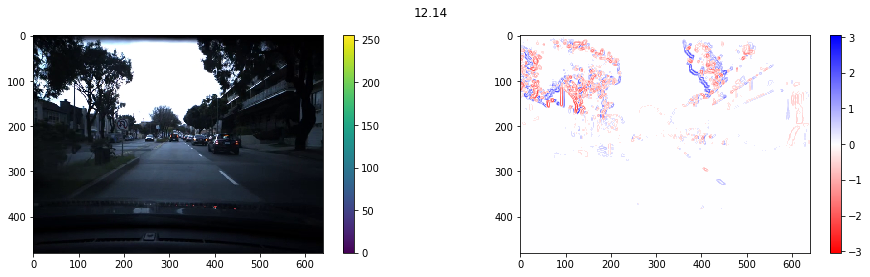

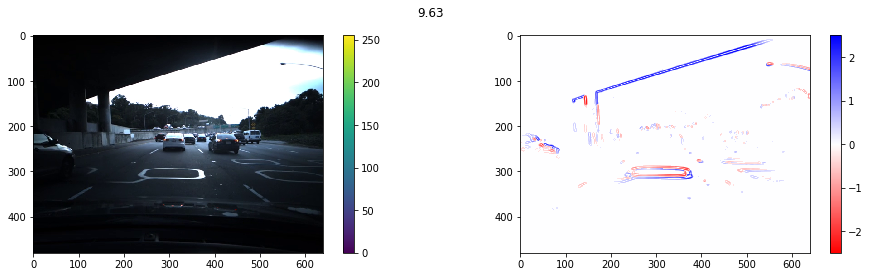

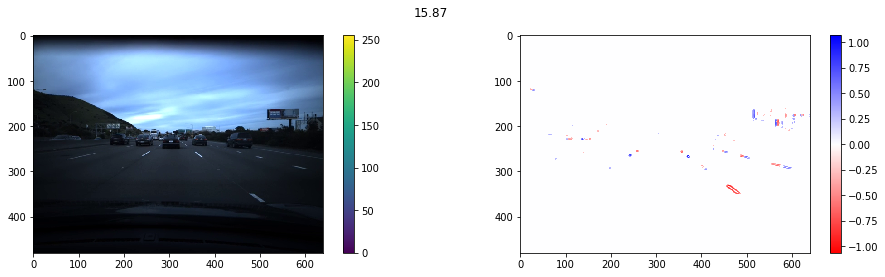

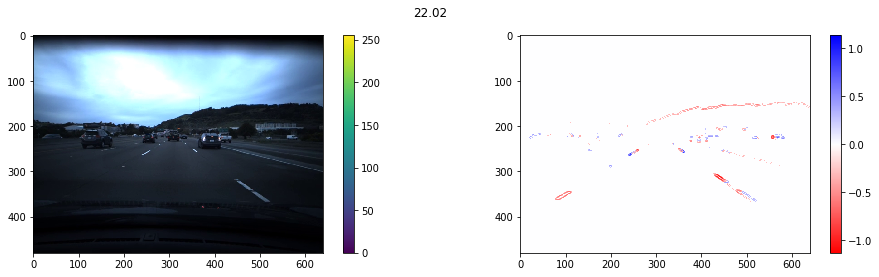

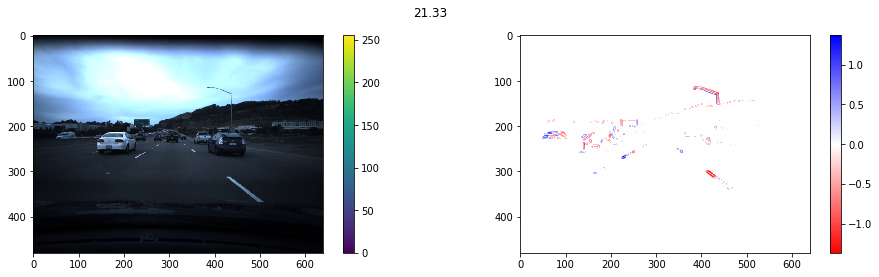

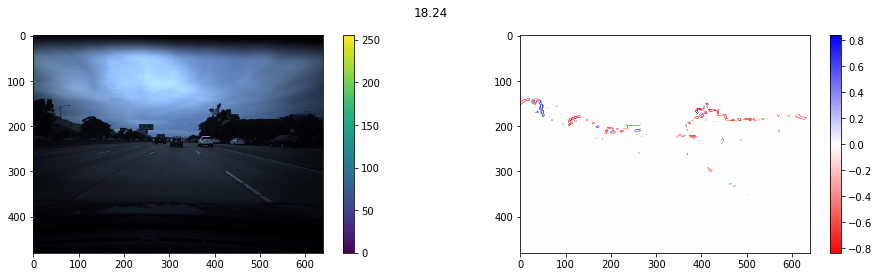

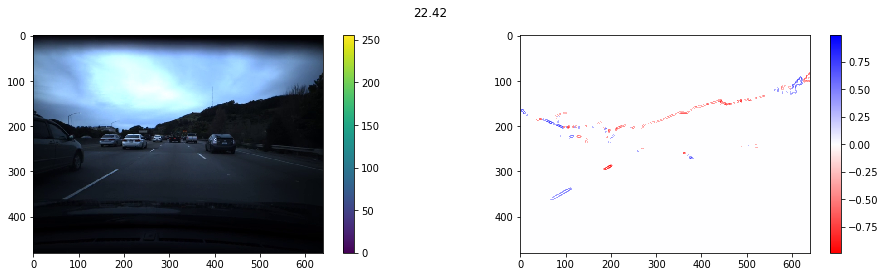

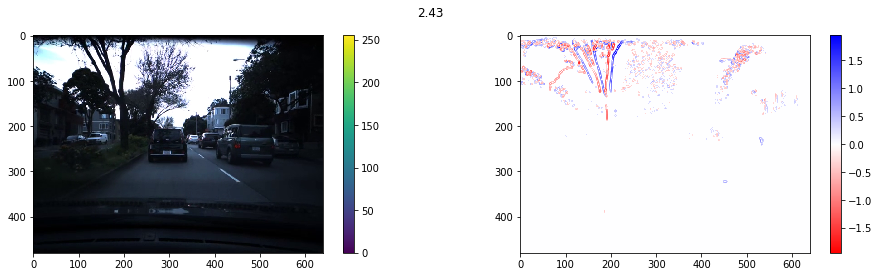

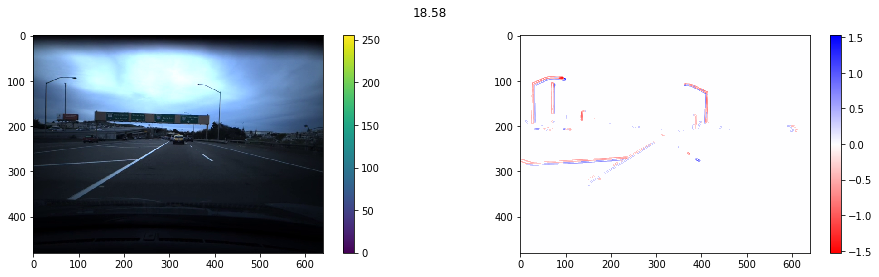

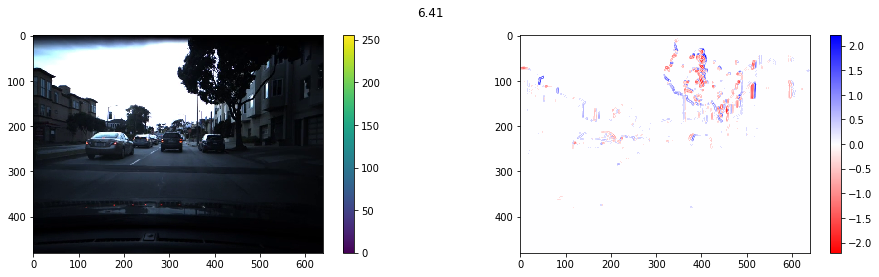

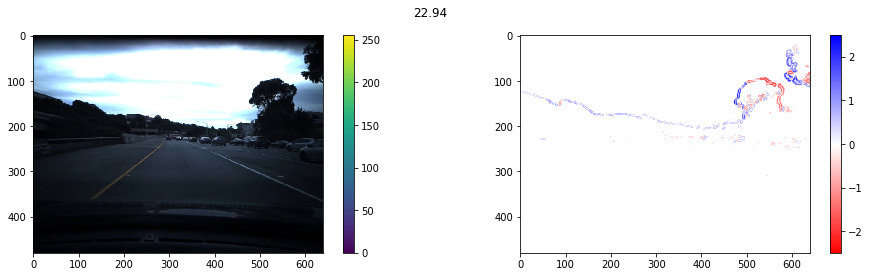

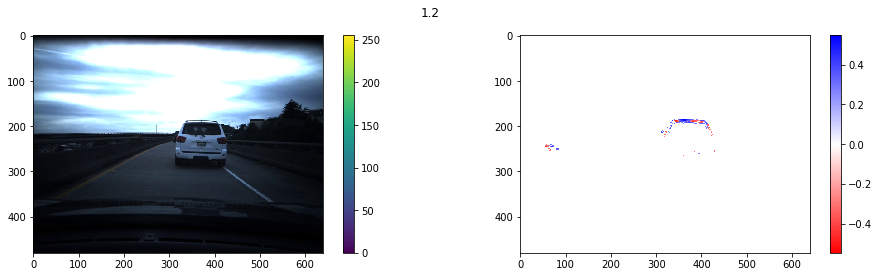

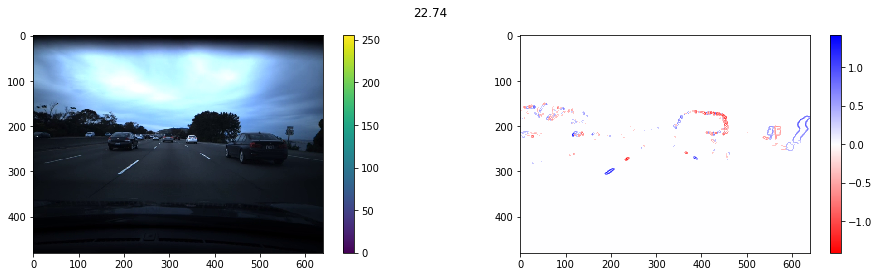

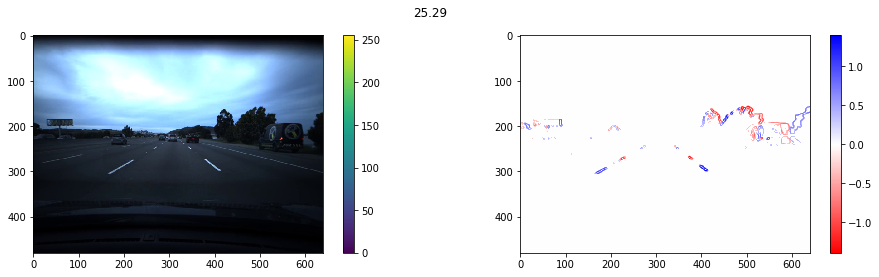

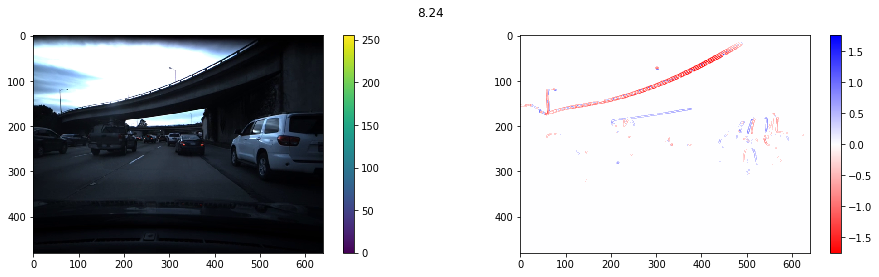

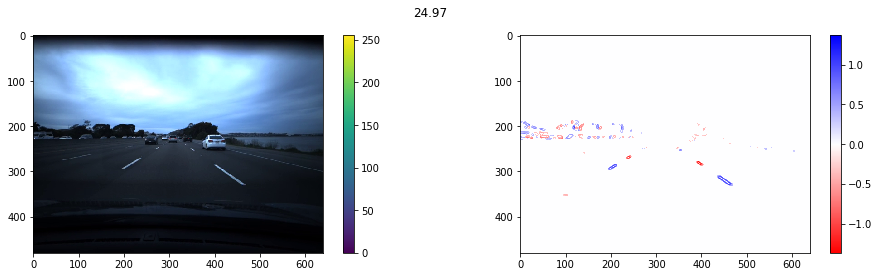

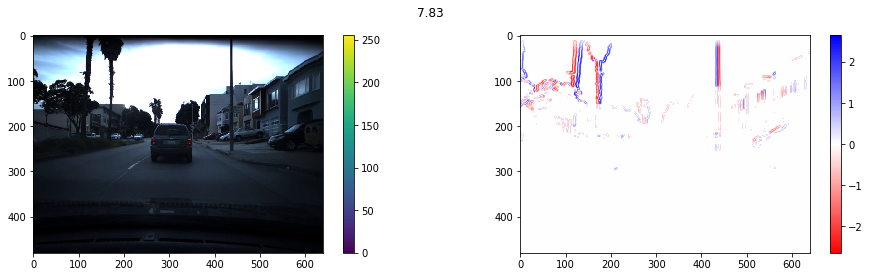

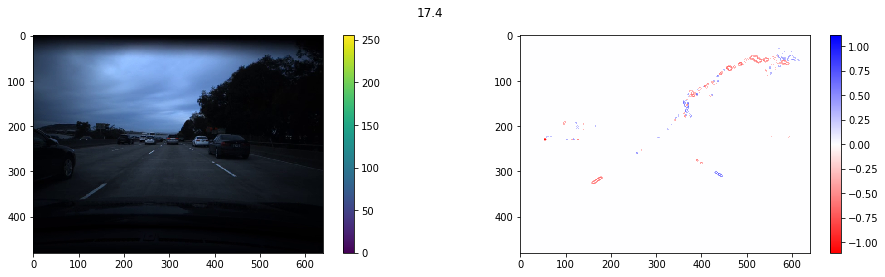

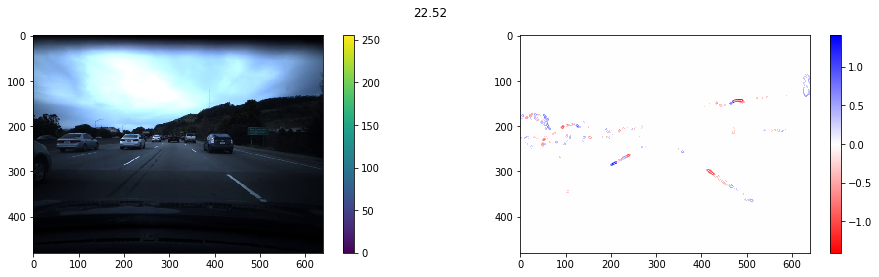

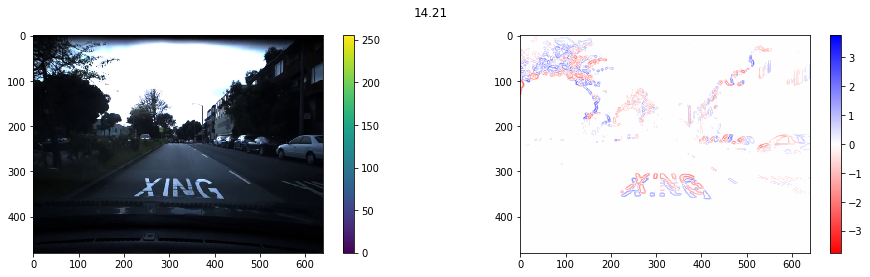

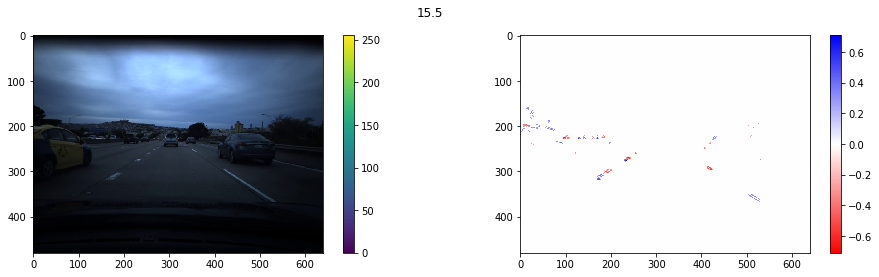

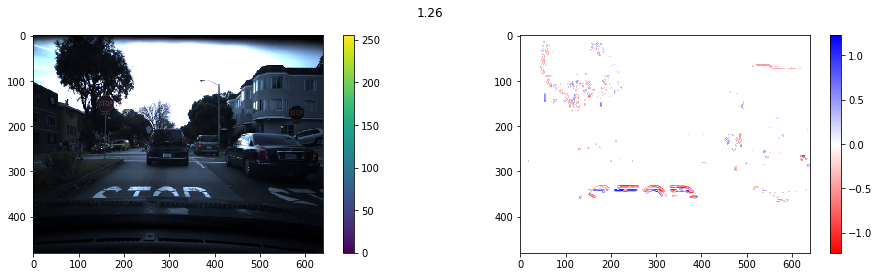

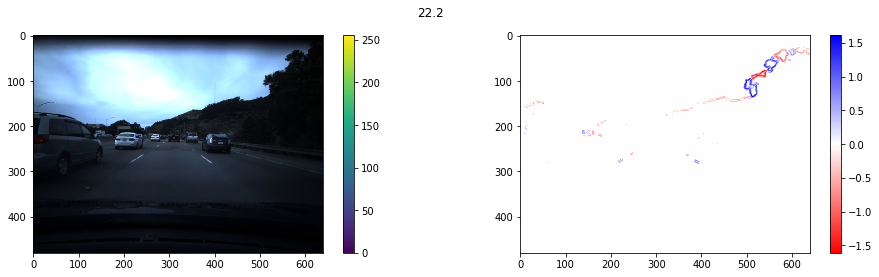

In [38]:
from scipy import ndimage

def train_generator(data, batch_size=32):
    rows, cols, channels = 480, 640, 5
    
    img_batch = np.zeros((batch_size, rows, cols, channels))
    lbl_batch = np.zeros(batch_size)
#     files = sorted(glob.glob('./train/*.npz')) == data
    nfiles = len(data)
    
    while 1:
        data_ids = np.random.choice(nfiles, size=batch_size, replace=False).astype('int')
        data_files = [np.load(data[i]) for i in data_ids]
        for i, d in enumerate(data_files):
            img_batch[i, :, :, 0:3] = d['color']
            img_batch[i, :, :, 3] =  d['dvs']*(d['dvs'] > 0)
            img_batch[i, :, :, 4] = -d['dvs']*(d['dvs'] < 0)
            lbl_batch[i] = np.round(d['label'], decimals=2)

        yield (img_batch, lbl_batch)

train_files = sorted(glob.glob('./train_010p/*.npz'))
thr = 0.25
fw = 4.0
for img, label in train_generator(train_files):
    for i in range(len(label)):
        rgb = img[i, :, :, 0:3]*255
        dvsP = ndimage.gaussian_filter(img[i, :, :, 3], 1)
        sx = ndimage.sobel(dvsP, axis=0, mode='constant')
        sy = ndimage.sobel(dvsP, axis=1, mode='constant')
        dvs = np.hypot(sx, sy)
        dvs *= (dvs > thr)
        
        dvsM = ndimage.gaussian_filter(img[i, :, :, 4], 1)
        sx = ndimage.sobel(dvsM, axis=0, mode='constant')
        sy = ndimage.sobel(dvsM, axis=1, mode='constant')
        tmp = np.hypot(sx, sy)
        tmp *= (tmp > thr)
        dvs[tmp > 0] = -tmp[tmp>0]
        
        plt.figure(figsize=(4*fw, fw))
        plt.suptitle(label[i])
        ax = plt.subplot(1, 2, 1)
        im = plt.imshow(cv2.cvtColor((rgb).astype('uint8'), cv2.COLOR_BGR2RGB))
        plt.colorbar(im)
        
        dmax = np.max(np.abs(dvs))
        ax = plt.subplot(1, 2, 2)
        im = plt.imshow(dvs, cmap='bwr_r',
                        vmin=-dmax,
                        vmax=dmax
                        )
        plt.colorbar(im)
    
    break

In [35]:
test_files = sorted(glob.glob('./test/*.npz'))
fw = 4.0
for img, label in train_generator(test_files):
    for i in range(label.size):
        plt.figure(figsize=(3*fw, fw))
        plt.suptitle(label[i])
        ax = plt.subplot(1, 2, 1)
        im = plt.imshow(cv2.cvtColor((img[i, :, :, 0:3]*255).astype('uint8'), cv2.COLOR_BGR2RGB))
        plt.colorbar(im)

        ax = plt.subplot(1, 2, 2)
        im = plt.imshow(img[i, :, :, 3], cmap='bwr_r',
                        vmin=-(np.max(np.abs(img[i, :, :, 3]))),
                        vmax=(np.max(np.abs(img[i, :, :, 3])))
                        )
        plt.colorbar(im)
    
    break

<generator object train_generator at 0x7f824b769230>

((32, 480, 640, 4), array([ 21.913223,  16.043478,   7.966842,  24.440926,  21.792604,
         0.925064,   4.139713,  18.542938,  22.004645,   4.114642,
        12.671987,   8.996812,  22.286694,  10.533034,   0.681805,
        22.490424,  22.26669 ,  22.087546,   0.529709,  20.852759,
         0.84709 ,  21.799272,   9.80728 ,  17.812789,   3.832414,
         5.031536,   5.513601,  22.327641,  18.336918,   9.879806,
        16.748279,  22.109089]))


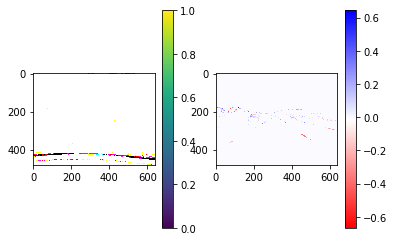